# a few visualizations to test the pca (NIKE) structure
1. male/female differences
2. shuffling experiments etc

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
notebook_dir = os.path.dirname(os.path.abspath(''))
if notebook_dir not in sys.path:
    sys.path.append(os.path.dirname(notebook_dir))
from notebooks.config import *
configure_matplotlib()

# Set figure directory 
SAVE_FIGURES = True
fig_path = SNRNA_FIGURE_DIR
from functools import partial
save_figure = partial(save_figure, dir_path=fig_path)

In [2]:
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys
import scanpy as sc
import pandas as pd
import anndata
from scipy.stats import spearmanr

import processing, utils, plotting, heatmap
import pseudoclusters, test_structures
print(f"scanpy version: {sc.__version__}")


scanpy version: 1.11.3


In [3]:
cpm_scl = 1e4

In [4]:
print("Loading snRNA-seq data...")
myfilename = os.path.join(SNRNA_DATA_DIR, "snRNAseq_LCNE_BN_d4_1-5k.h5ad")

adata_foo = sc.read_h5ad(myfilename)
adata_BN = anndata.AnnData(adata_foo.layers['BN'])
adata_BN.obs = adata_foo.obs.copy()
adata_BN.obsm = adata_foo.obsm.copy()
adata_BN.var = adata_foo.var.copy()

print(f"Data shape: {adata_BN.shape}")

# Prepare data for analysis
print("Preparing data for analysis...")
adata_sc = adata_BN.copy()
adata_sc.raw=adata_sc.copy()

sc.pp.scale(adata_sc, zero_center=True, max_value=10)
sc.tl.pca(adata_sc, n_comps=50, svd_solver='arpack')



Loading snRNA-seq data...
Data shape: (4895, 1500)
Preparing data for analysis...


# 1. gender differences on pca

In [5]:
adata_sc_M = adata_sc[adata_sc.obs['sex'] == "M"].copy()
adata_sc_F = adata_sc[adata_sc.obs['sex'] == "F"].copy()


sc.pp.scale(adata_sc_M, zero_center=True, max_value=10)
sc.tl.pca(adata_sc_M, n_comps=50, svd_solver='arpack')
sc.pp.scale(adata_sc_F, zero_center=True, max_value=10)
sc.tl.pca(adata_sc_F, n_comps=50, svd_solver='arpack')


In [6]:
adata_sc_M.shape, adata_sc_F.shape

((2595, 1500), (2300, 1500))

Exploring PCA dimensions...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_dimensions.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_dimensions.png


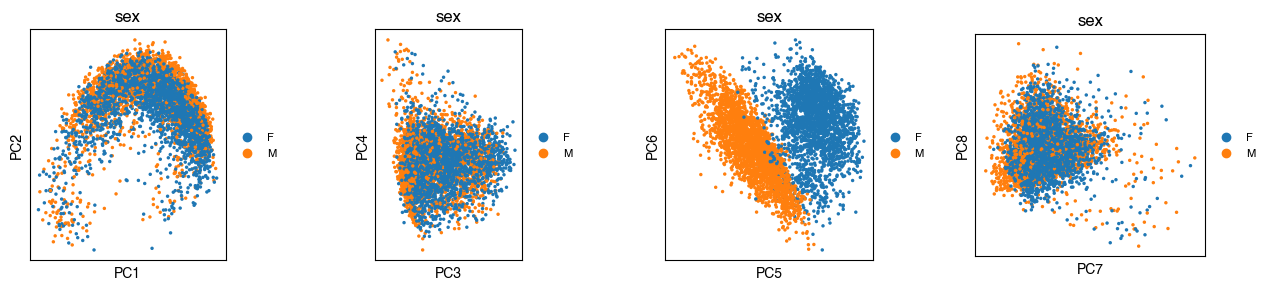

In [7]:
# PCA Exploratory Analysis
print("Exploring PCA dimensions...")

# Plot first few PCA dimensions
with plt.rc_context({"figure.figsize": (3, 3)}):    
    ax = sc.pl.pca(adata_sc, dimensions=((0, 1), (2, 3), (4, 5), (6, 7)), 
                  show=False, color='sex')
    for a in ax: 
        a.set_aspect('equal')
    save_figure("pca_dimensions")
    plt.show()

/tmp/ipykernel_636/1855355060.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_dimensions_males.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_dimensions_males.png


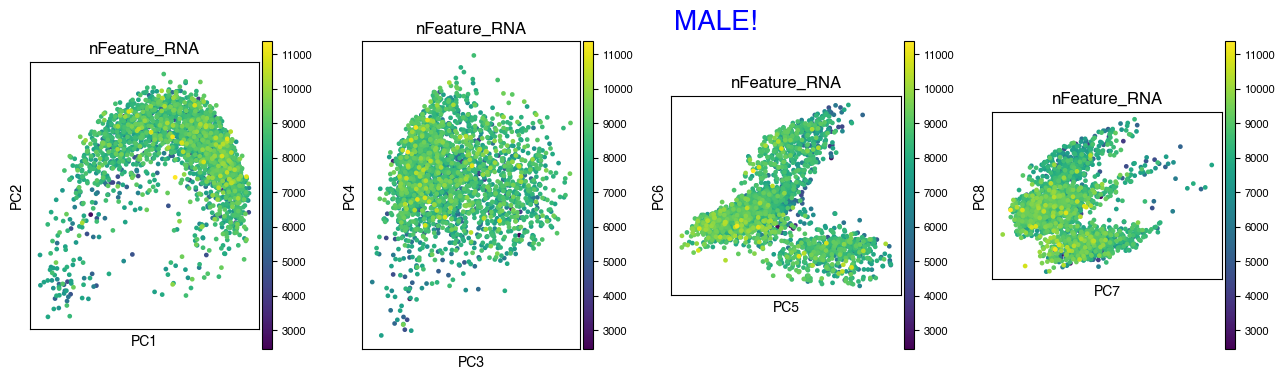

/tmp/ipykernel_636/1855355060.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_dimensions_females.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_dimensions_females.png


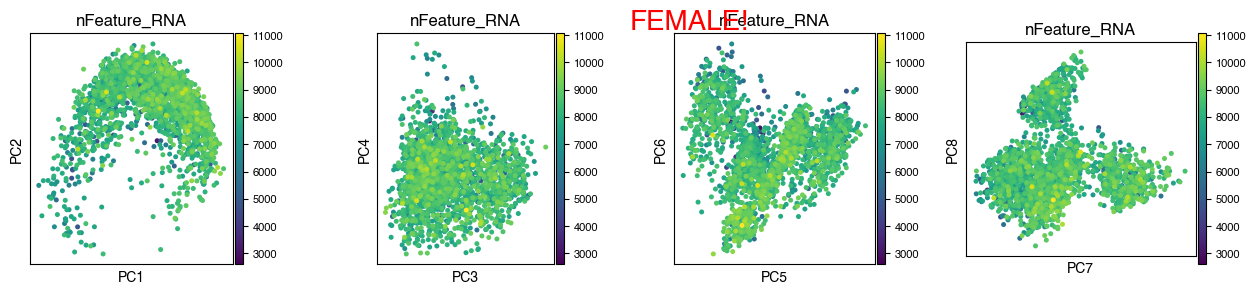

In [8]:
with plt.rc_context({"figure.figsize": (3,4)}):    
    ax = sc.pl.pca(adata_sc_M, dimensions=((0, 1), (2, 3), (4, 5), (6, 7)), 
                  show=False, color='nFeature_RNA')
    for a in ax: 
        a.set_aspect('equal')
    plt.suptitle("MALE!", fontsize = '20',color = 'blue')
    plt.tight_layout()
    save_figure("pca_dimensions_males")
    plt.show()

with plt.rc_context({"figure.figsize": (3,3)}):    
    ax = sc.pl.pca(adata_sc_F, dimensions=((0, 1), (2, 3), (4, 5), (6, 7)), 
                  show=False, color='nFeature_RNA')
    for a in ax: 
        a.set_aspect('equal')
    plt.suptitle("FEMALE!", fontsize = '20',color = 'red')
    plt.tight_layout()
    save_figure("pca_dimensions_females")
    plt.show()    

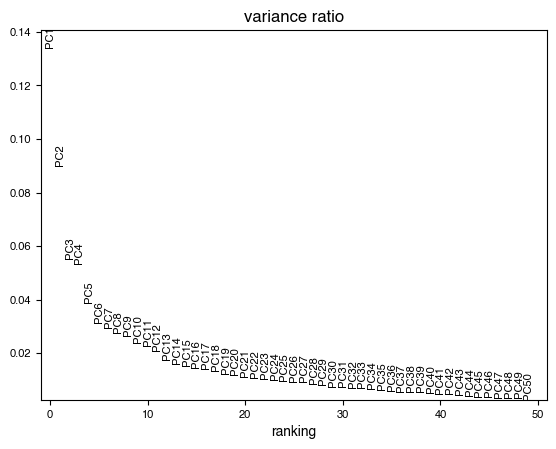

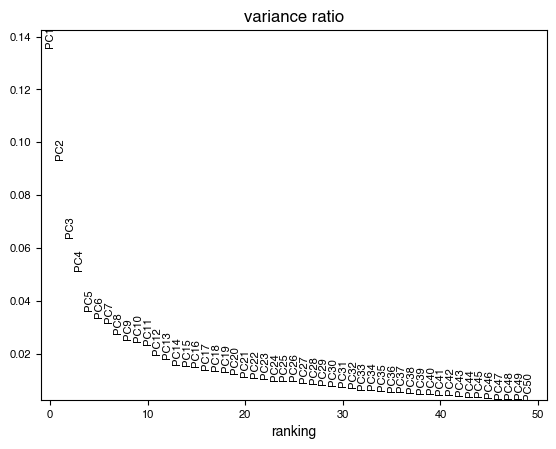

MALE: Variance explained by top 10 PCs: 0.511
FEMALE: Variance explained by top 10 PCs: 0.523


In [9]:

# Check explained variance
sc.pl.pca_variance_ratio(adata_sc_M, n_pcs=50, log=False)
sc.pl.pca_variance_ratio(adata_sc_F, n_pcs=50, log=False)
print(f"MALE: Variance explained by top 10 PCs: {adata_sc_M.uns['pca']['variance_ratio'][:10].sum():.3f}")
print(f"FEMALE: Variance explained by top 10 PCs: {adata_sc_F.uns['pca']['variance_ratio'][:10].sum():.3f}")


# 2. permutation analysis to validate PCA structures

## 1) Prepare the range of permutation counts

In [10]:

max_genes = adata_sc.shape[1]
n_perms_list = np.unique(
    np.concatenate([
        np.arange(20, 101, 20),                        # 20,40,…,100
        np.linspace(150, max_genes, 6, dtype=int)      # up to all genes
    ])
)
n_perms_list = n_perms_list[n_perms_list <= max_genes]
n_perms_list_subset = [20,int(max_genes/2), int(max_genes*0.99), max_genes]
print(n_perms_list_subset)

[20, 750, 1485, 1500]


## 2) run permutation and plot examples

Performing permutation analysis to validate PCA structure...
...20...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_permutation_comparison_20.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_permutation_comparison_20.png


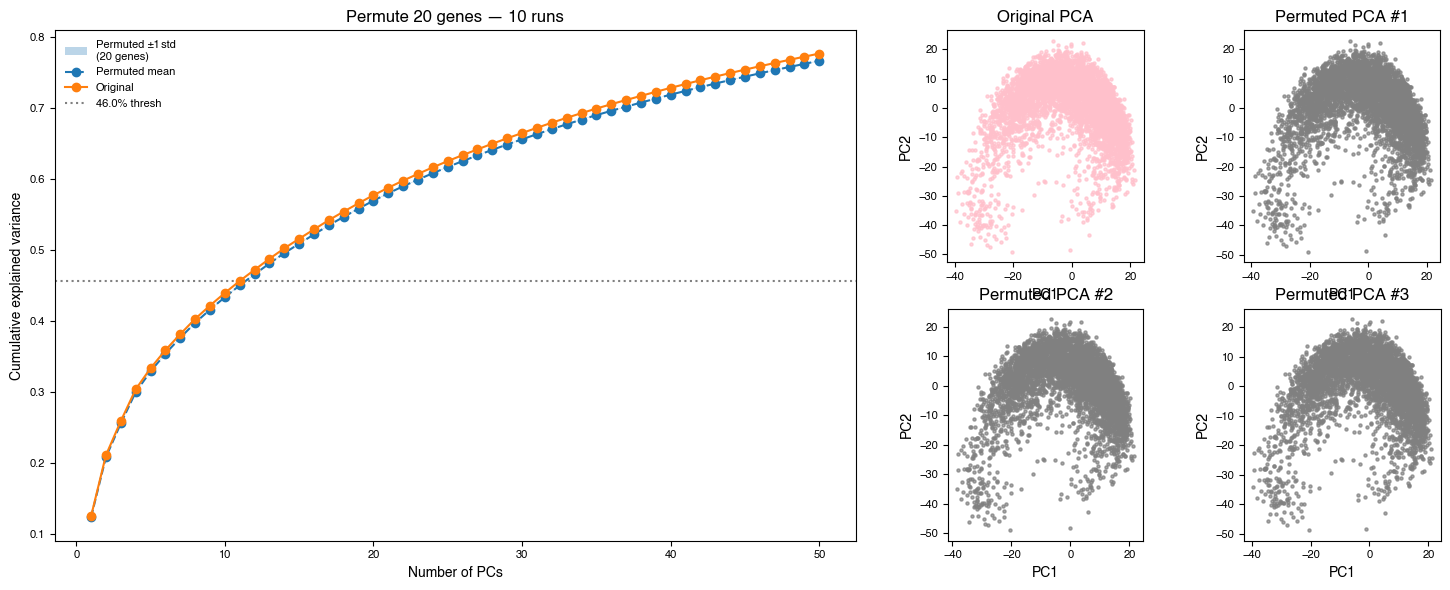

...750...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_permutation_comparison_750.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_permutation_comparison_750.png


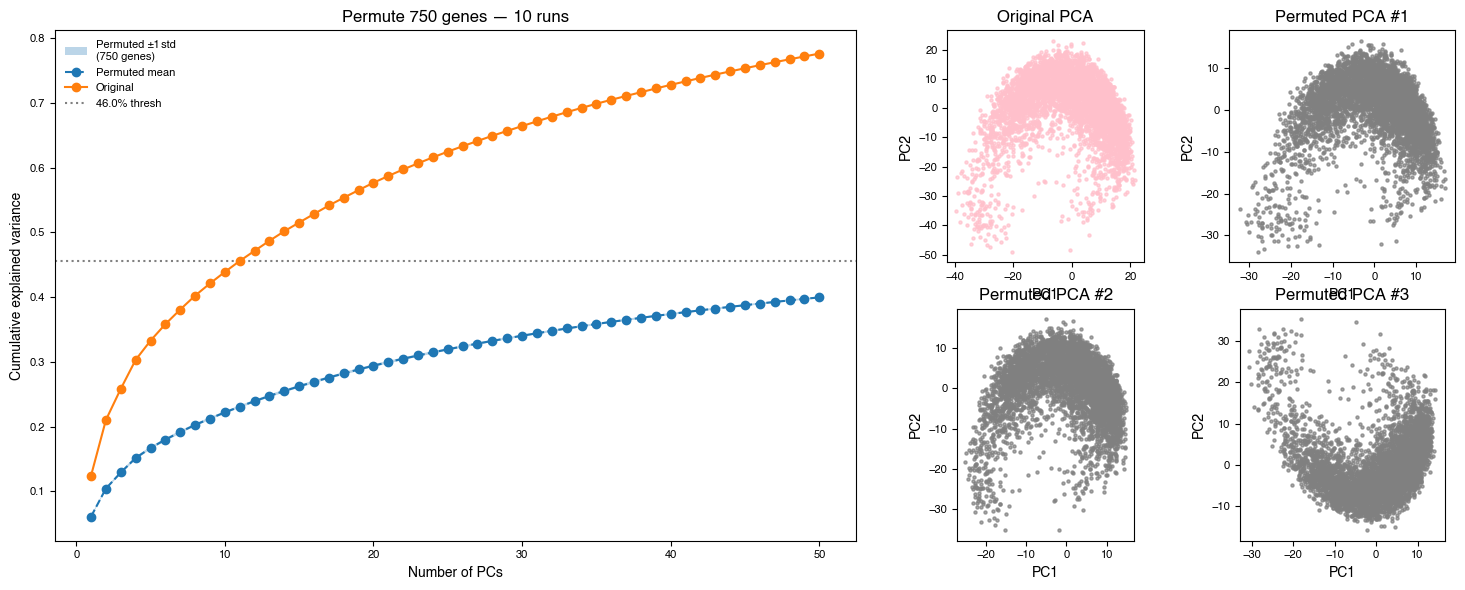

...1485...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_permutation_comparison_1485.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_permutation_comparison_1485.png


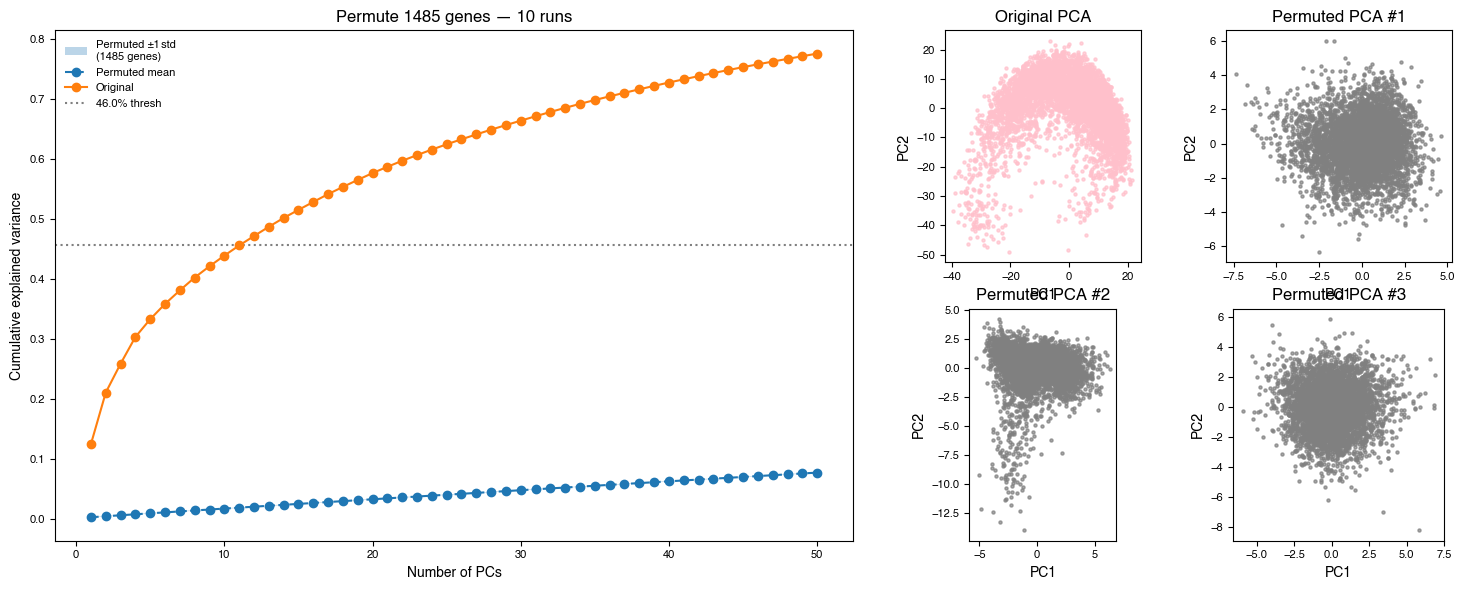

...1500...
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_permutation_comparison_1500.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_permutation_comparison_1500.png


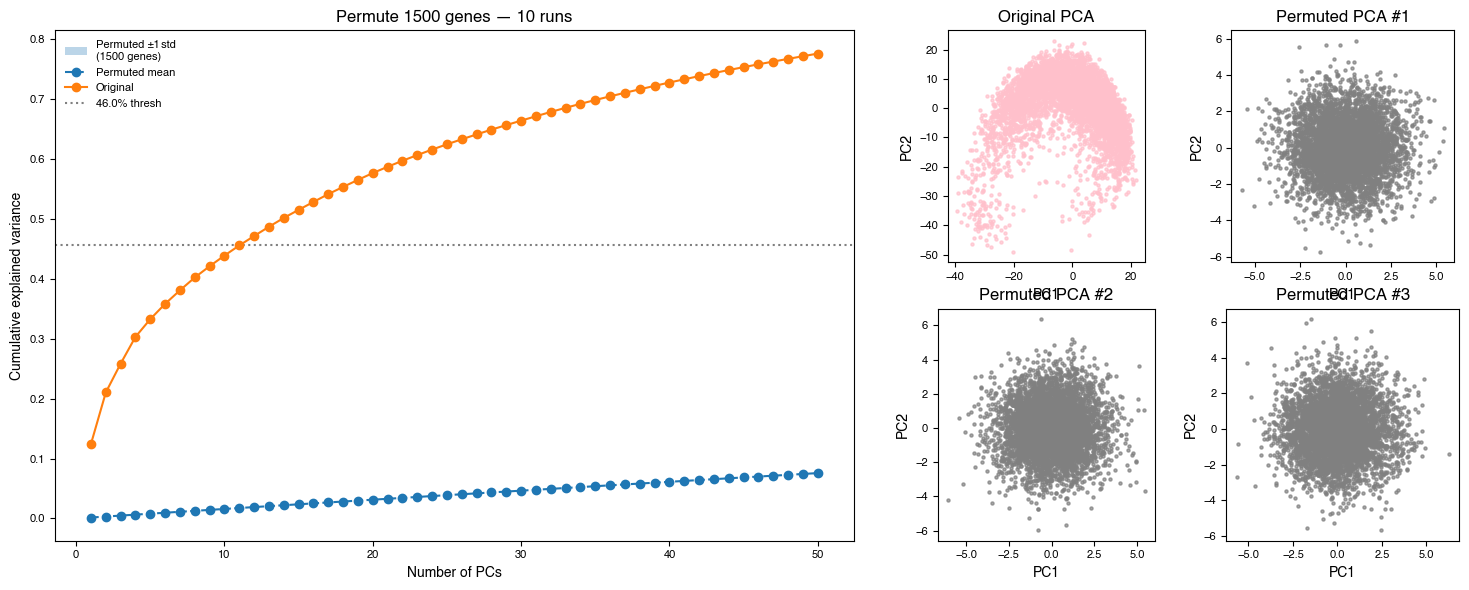

In [11]:
print("Performing permutation analysis to validate PCA structure...")
for n_perm_genes in n_perms_list_subset:
    print(f'...{n_perm_genes}...')
    (all_fig, all_axes) = test_structures.compare_permuted_pca_cumulative(
        adata_sc,
        n_perm_genes=n_perm_genes,   # change this line to change the num of genes 
        n_pcs=50,
        n_perms=10,
        n_examples=3,
        seed=42
    )
    save_figure(f"pca_permutation_comparison_{n_perm_genes}", dir_path=fig_path)
    plt.show()

## 3) some gap visualizations

In [12]:
import scipy.sparse as sp

Running permutations for 20 genes…
Running permutations for 40 genes…
Running permutations for 60 genes…
Running permutations for 80 genes…
Running permutations for 100 genes…
Running permutations for 150 genes…
Running permutations for 420 genes…
Running permutations for 690 genes…
Running permutations for 960 genes…
Running permutations for 1230 genes…
Running permutations for 1500 genes…
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_cumulative_explained_varying_gene_permute.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_cumulative_explained_varying_gene_permute.png


<Figure size 640x480 with 0 Axes>

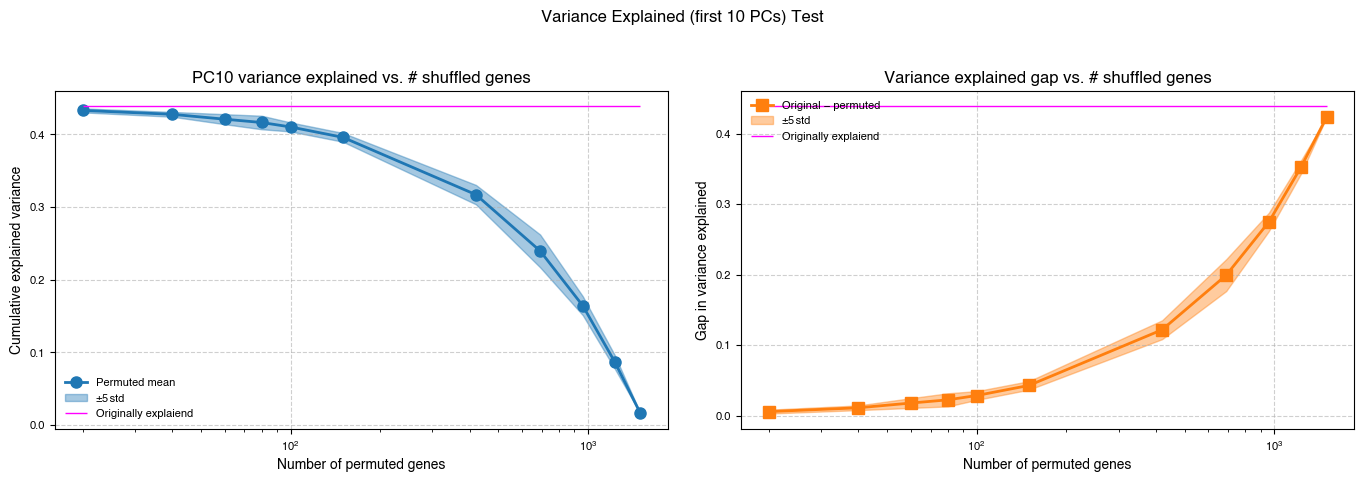

In [16]:
# 1) Compute original PCA cumulative variance
sc.tl.pca(adata_sc, n_comps=50, svd_solver='arpack')
orig_cum = np.cumsum(adata_sc.uns['pca']['variance_ratio'])
orig_pc10 = orig_cum[9]  # PC 10 (zero-indexed)

# 2) For each n_perms, run that many shuffles & PCA, collect mean & std cum-var at PC 10
perm10_means = []
perm10_stds  = []
gaps         = []
seed         = 42
N            = 10  # number of repetitions per n_perm_genes
for n_perm_genes in n_perms_list:
    print(f"Running permutations for {n_perm_genes} genes…")
    rng = np.random.default_rng(seed)
    perm_cums = []
    for _ in range(N):
        # start from fresh X
        X = adata_sc.X.toarray() if sp.issparse(adata_sc.X) else adata_sc.X.copy()
        # permute exactly n_perm_genes columns
        cols = rng.choice(X.shape[1], size=n_perm_genes, replace=False)
        for gi in cols:
            rng.shuffle(X[:, gi])
        # run PCA on permuted data
        ad = adata_sc.copy()
        ad.X = X
        sc.tl.pca(ad, n_comps=50, svd_solver='arpack')
        perm_cums.append(np.cumsum(ad.uns['pca']['variance_ratio']))
    perm_arr = np.vstack(perm_cums)
    mean_perm = perm_arr.mean(0)
    std_perm  = perm_arr.std(0)

    perm10_means.append(mean_perm[9])
    perm10_stds.append(std_perm[9])
    gaps.append(orig_pc10 - mean_perm[9])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
means = np.array(perm10_means)
stds  = 5*np.array(perm10_stds)
orig  = orig_pc10
x     = n_perms_list
# ---- Panel A: PC10 variance ----
ax = axes[0]
ax.plot(x, means, marker='o', ms=8, lw=2, color='C0', label='Permuted mean')
ax.fill_between(x, means - stds, means + stds,
                color='C0', alpha=0.4, label='±5 std')
ax.hlines(orig, x.min(), x.max(),
          color='magenta', lw=1, linestyle='-', label='Originally explaiend')
ax.set_xscale('log')
# ax.set_xticks(x);ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlabel('Number of permuted genes')
ax.set_ylabel('Cumulative explained variance')
ax.set_title('PC10 variance explained vs. # shuffled genes')
ax.legend(loc='lower left', frameon=False)
ax.grid(True, which='major', linestyle='--', alpha=0.6)
# ---- Panel B: Gap ----
ax = axes[1]
ax.plot(x, gaps, marker='s', ms=8, lw=2, color='C1', label='Original − permuted')
ax.fill_between(x, gaps - stds, gaps + stds,
                color='C1', alpha=0.4, label='±5 std')
ax.hlines(orig, x.min(), x.max(),
          color='magenta', lw=1, linestyle='-', label='Originally explaiend')

ax.set_xscale('log')
ax.set_xlabel('Number of permuted genes')
ax.set_ylabel('Gap in variance explained')
ax.set_title('Variance explained gap vs. # shuffled genes')
ax.legend(loc='upper left', frameon=False)
ax.grid(True, which='major', linestyle='--', alpha=0.6)

plt.suptitle('Variance Explained (first 10 PCs) Test')
plt.tight_layout(pad=2)
save_figure(f"pca_cumulative_explained_varying_gene_permute", dir_path=fig_path)
plt.show()


# Test how PCA varies with different numbers of HVGs

Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_hvg_variation.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/snRNA/pca_hvg_variation.png


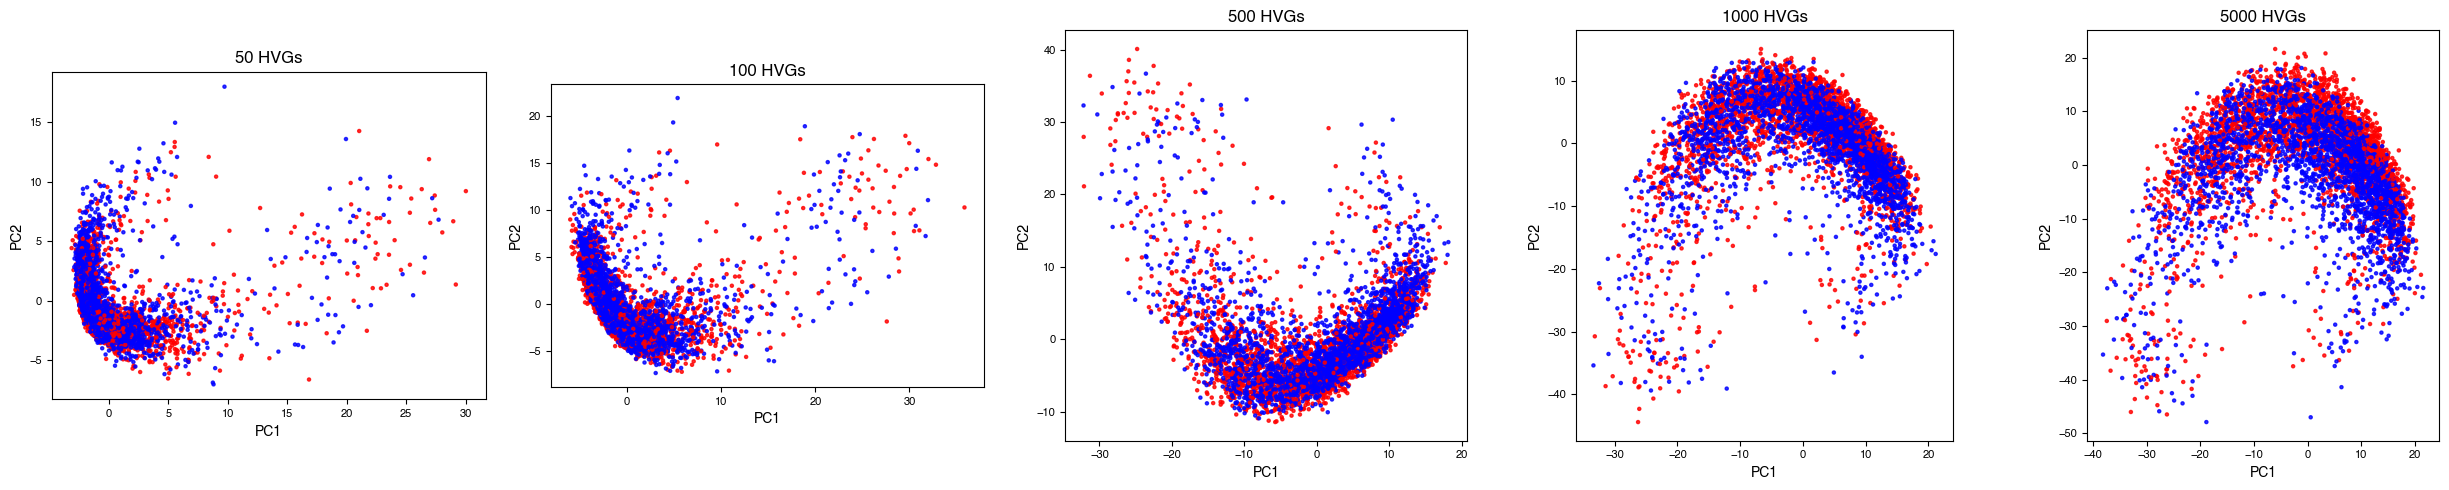

In [17]:
(all_fig, all_axes) = test_structures.plot_pca_hvg_variation(
    adata_BN,cpm_scl=cpm_scl,
    hvg_counts=[50, 100, 500, 1000, 5000],
    scatter_kwargs={'s': 5, 'alpha': 0.8, 'c': adata_BN.obs['sex'].cat.codes, 'cmap': 'bwr'}
)
save_figure("pca_hvg_variation", dir_path=fig_path)
plt.show()